# Continuous Evaluation

This notebook demonstrates how to use Cloud AI Platform to execute continuous evaluation of a deployed machine learning model. You'll need to have a project set up with Google Cloud Platform. 

## Set up
Start by creating environment variables for your Google Cloud project and bucket. Also, import the libraries we'll need for this notebook.

In [2]:
# change these to try this notebook out
PROJECT = 'munn-sandbox'
BUCKET = 'munn-sandbox'

In [3]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['TFVERSION'] = '2.1'

In [5]:
import shutil

import pandas as pd
import tensorflow as tf

from google.cloud import bigquery
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow_hub import KerasLayer
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.models import Model
print(tf.__version__)

%matplotlib inline

2.2.0


## Train and deploy the model
For this notebook, we'll build a text classification model using the Hacker News dataset. Each training example consists of an article title and the article source. The model will be trained to classify a given article title as belonging to either `nytimes`, `github` or `techcrunch`.

#### Load the data

In [8]:
DATASET_NAME = "titles_full.csv"
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(DATASET_NAME, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,led inventor and employer settle for $8.1m 2005,nytimes
1,yc-backed photo-sharing service picplum loses ...,techcrunch
2,as facebook turns 10 zuckerberg wants to chan...,nytimes
3,6 big healthtech ideas that will change medici...,techcrunch
4,building the prince of persia sources to creat...,github


 We one-hot encode the label...

In [9]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [10]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [11]:
encode_labels(titles_df.source[:4])

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

...and create a train/test split.

In [12]:
N_TRAIN = int(len(titles_df) * 0.80)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

In [13]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [14]:
X_train[:3]

array(['led inventor and employer settle for $8.1m  2005 ',
       'yc-backed photo-sharing service picplum loses one co-founder',
       'as facebook turns 10  zuckerberg wants to change how tech industry works'],
      dtype=object)

### Swivel Model

We'll build a simple text classification model using a Tensorflow Hub embedding module derived from Swivel. [Swivel](https://arxiv.org/abs/1602.02215) is an algorithm that essentially factorizes word co-occurrence matrices to create the words embeddings. 
TF-Hub hosts the pretrained [gnews-swivel-20dim-with-oov](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) 20-dimensional Swivel module.

In [15]:
SWIVEL = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
swivel_module = KerasLayer(SWIVEL, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True)

The `build_model` function is written so that the TF Hub module can easily be exchanged with another module.

In [16]:
def build_model(hub_module, model_name):
    inputs = Input(shape=[], dtype=tf.string, name="text")
    module = hub_module(inputs)
    h1 = Dense(16, activation='relu', name="h1")(module)
    outputs = Dense(N_CLASSES, activation='softmax', name='outputs')(h1)
    model = Model(inputs=inputs, outputs=[outputs], name=model_name)
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [17]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    tf.random.set_seed(33)    
    X_train, Y_train = train_data

    history = model.fit(
        X_train, Y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=[EarlyStopping()],
    )
    return history

In [18]:
txtcls_model = build_model(swivel_module, model_name='txtcls_swivel')

In [19]:
txtcls_model.summary()

Model: "txtcls_swivel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None,)]                 0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 20)                389380    
_________________________________________________________________
h1 (Dense)                   (None, 16)                336       
_________________________________________________________________
outputs (Dense)              (None, 3)                 51        
Total params: 389,767
Trainable params: 389,767
Non-trainable params: 0
_________________________________________________________________


### Train and evaluation the model
With the model defined and data set up, next we'll train and evaluate the model.

In [20]:
# set up train and validation data
train_data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

For training we'll call `train_and_evaluate` on `txtcls_model`.

In [21]:
txtcls_history = train_and_evaluate(train_data, val_data, txtcls_model)

Epoch 1/100
16/16 [==============================] - 1s 45ms/step - loss: 1.3334 - accuracy: 0.3129 - val_loss: 1.2283 - val_accuracy: 0.3434
Epoch 2/100
16/16 [==============================] - 0s 30ms/step - loss: 1.1785 - accuracy: 0.3797 - val_loss: 1.1155 - val_accuracy: 0.4178
Epoch 3/100
16/16 [==============================] - 1s 34ms/step - loss: 1.0804 - accuracy: 0.4463 - val_loss: 1.0397 - val_accuracy: 0.4774
Epoch 4/100
16/16 [==============================] - 0s 29ms/step - loss: 1.0114 - accuracy: 0.4988 - val_loss: 0.9824 - val_accuracy: 0.5200
Epoch 5/100
16/16 [==============================] - 0s 29ms/step - loss: 0.9571 - accuracy: 0.5420 - val_loss: 0.9346 - val_accuracy: 0.5554
Epoch 6/100
16/16 [==============================] - 0s 30ms/step - loss: 0.9109 - accuracy: 0.5765 - val_loss: 0.8926 - val_accuracy: 0.5882
Epoch 7/100
16/16 [==============================] - 0s 31ms/step - loss: 0.8691 - accuracy: 0.6067 - val_loss: 0.8539 - val_accuracy: 0.6149
Epoch 

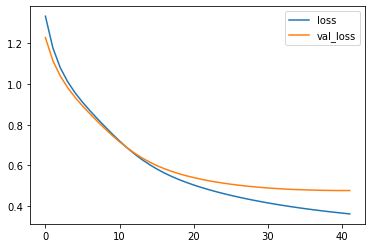

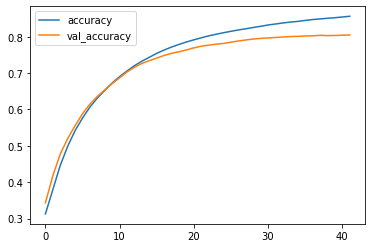

In [22]:
history = txtcls_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

Calling predicition from model head produces output from final dense layer. This final layer is used to compute categorical cross-entropy when training. 

In [23]:
txtcls_model.predict(x=["YouTube introduces Video Chapters to make it easier to navigate longer videos"])

array([[0.81729865, 0.02749203, 0.1552093 ]], dtype=float32)

We can save the model artifacts in the local directory called `./txtcls_swivel`.

In [24]:
tf.saved_model.save(txtcls_model, './txtcls_swivel/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./txtcls_swivel/assets


INFO:tensorflow:Assets written to: ./txtcls_swivel/assets


....and examine the model's serving default signature. As expected the model takes as input a text string (e.g. an article title) and retrns a 3-dimensional vector of floats (i.e. the softmax output layer).

In [25]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir ./txtcls_swivel/

The given SavedModel SignatureDef contains the following input(s):
  inputs['text'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_text:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['outputs'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall_2:0
Method name is: tensorflow/serving/predict


To simplify the returned predictions, we'll modify the model signature so that the model outputs the predicted article source (either `nytimes`, `techcrunch`, or `github`) rather than the final softmax layer. We'll also return the 'confidence' of the model's prediction. This will be the softmax value corresonding to the predicted article source.

In [32]:
@tf.function(input_signature=[tf.TensorSpec([None], dtype=tf.string)])
def source_name(text):
    labels = tf.constant(['github', 'nytimes', 'techcrunch'], dtype=tf.string)
    probs = txtcls_model(text, training=False)
    indices = tf.argmax(probs, axis=1)
    pred_source = tf.gather(params=labels, indices=indices)
    pred_confidence = tf.reduce_max(probs, axis=1)
    
    return {'source': pred_source,
            'confidence': pred_confidence}

Now, we'll re-save the new Swivel model that has this updated model signature by referencing the `source_name` function for the model's `serving_default`.

In [33]:
shutil.rmtree('./txtcls_swivel', ignore_errors=True)
txtcls_model.save('./txtcls_swivel', signatures={'serving_default': source_name})

INFO:tensorflow:Assets written to: ./txtcls_swivel/assets


INFO:tensorflow:Assets written to: ./txtcls_swivel/assets


Examine the model signature to confirm the changes:

In [34]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir ./txtcls_swivel/

The given SavedModel SignatureDef contains the following input(s):
  inputs['text'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_text:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['confidence'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: StatefulPartitionedCall_2:0
  outputs['source'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: StatefulPartitionedCall_2:1
Method name is: tensorflow/serving/predict


Now when we call predictions using the updated serving input function, the model will return the predicted article source as a readable string, and the model's confidence for that prediction.

In [37]:
title1 = "House Passes Sweeping Policing Bill Targeting Racial Bias and Use of Force"
title2 = "YouTube introduces Video Chapters to make it easier to navigate longer videos"
title3 = "As facebook turns 10  zuckerberg wants to change how tech industry works"

restored = tf.keras.models.load_model('./txtcls_swivel')
infer = restored.signatures['serving_default']
outputs = infer(text=tf.constant([title1, title2, title3]))

In [38]:
print(outputs['source'].numpy())
print(outputs['confidence'].numpy())

[b'github' b'github' b'techcrunch']
[0.9840866 0.8172988 0.9124565]


### Deploy the model for online serving

Once the model is trained and the assets saved, deploying the model to GCP is straightforward. After some time you should be able to see your deployed model and its version on the [model page of GCP console](https://console.cloud.google.com/ai-platform/models).

In [40]:
%%bash
MODEL_NAME="txtcls"
MODEL_VERSION="swivel"
MODEL_LOCATION="./txtcls_swivel/"

gcloud ai-platform models create ${MODEL_NAME}

gcloud ai-platform versions create ${MODEL_VERSION} \
--model ${MODEL_NAME} \
--origin ${MODEL_LOCATION} \
--staging-bucket gs://${BUCKET} \
--runtime-version=2.1

Using endpoint [https://ml.googleapis.com/]

Learn more about regional endpoints and see a list of available regions: https://cloud.google.com/ai-platform/prediction/docs/regional-endpoints
Created ml engine model [projects/munn-sandbox/models/txtcls_mm].
Using endpoint [https://ml.googleapis.com/]
Creating version (this might take a few minutes)......
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................done.


## Set up the Evaluation job on CAIP

Now that the model is deployed, go to [Cloud AI Platform](https://console.cloud.google.com/ai-platform/models/txtcls/versions) to see the model version you've deployed and [set up an evaluation job](https://console.cloud.google.com/ai-platform/models/txtcls/versions/swivel/evaluation) by clicking on the button called "Create Evaluation Job". You will be asked to provide some relevant information:
 - Job description: txtcls_swivel_eval
 - Model objective: text classification
 - Classification type: single-label classification
 - Prediction label file path for the annotation specification set: When you create an evaluation job on CAIP, you must specify a CSV file that defines your annotation specification set. This file must have one row for every possible label your model outputs during prediction. Each row should be a comma-separated pair containing the label and a description of the label: label-name,description
 - Daily sample percentage: We'll set this to 100% so that all online predicitons are captured for evaluation.
 - BigQuery table to house online prediction requests: We'll use the BQ dataset and table `txtcls_eval.swivel`. If you enter a BigQuery table that doesn’t exist, one with that name will be created with the correct schema. 
 - Prediction input
     - Data key: this is The key for the raw prediction data. From examining our deployed model signature, the input data key is `text`.
     - Data reference key: this is for image models, so we can ignore
 - Prediction output
     - Prediction labels key: This is the prediction key which contains the predicted label (i.e. the article source). For our model, the label key is `source`.
     - Prediction score key: This is the prediction key which contains the predicted scores (i.e. the model confidence). For our model, the score key is `confidence`.
 - Ground-truth method: Check the box that indicates we will provide our own labels, and not use a Human data labeling service.
 

Once the evaluation job is set up, the table will be made in BigQuery to capture the online prediction requests. 

In [70]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [99]:
%%bigquery --project $PROJECT
SELECT * FROM `txtcls_eval.swivel`

,model,model_version,time,raw_data,raw_prediction,groundtruth


Now, every time this model version receives an online prediction request, this information will be captured and stored in the BQ table. Note, this happens everytime because we set the sampling proportion to 100%. 

## Send prediction requests to your model

Here are some article titles and their groundtruth sources that we can test with prediciton.

| title  | groundtruth  |
|---|---|
| YouTube introduces Video Chapters to make it easier to navigate longer videos  |  techcrunch |
| A Filmmaker Put Away for Tax Fraud Takes Us Inside a British Prison | nytimes |
| A native Mac app wrapper for WhatsApp Web | github |
| Astronauts Dock With Space Station After Historic SpaceX Launch | nytimes |
| House Passes Sweeping Policing Bill Targeting Racial Bias and Use of Force | nytimes |
| Scrollability | github |
| iOS 14 lets deaf users set alerts for important sounds, among other clever accessibility perks | techcrunch |

In [100]:
%%writefile input.json
{"text": "YouTube introduces Video Chapters to make it easier to navigate longer videos"}

Overwriting input.json


In [101]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

CONFIDENCE  SOURCE
0.512727    techcrunch


In [102]:
%%writefile input.json
{"text": "A Filmmaker Put Away for Tax Fraud Takes Us Inside a British Prison"}

Overwriting input.json


In [103]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

CONFIDENCE  SOURCE
0.429436    techcrunch


In [104]:
%%writefile input.json
{"text": "A native Mac app wrapper for WhatsApp Web"}

Overwriting input.json


In [105]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

CONFIDENCE  SOURCE
0.482146    techcrunch


In [106]:
%%writefile input.json
{"text": "Astronauts Dock With Space Station After Historic SpaceX Launch"}

Overwriting input.json


In [107]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

CONFIDENCE  SOURCE
0.516605    techcrunch


In [108]:
%%writefile input.json
{"text": "House Passes Sweeping Policing Bill Targeting Racial Bias and Use of Force"}

Overwriting input.json


In [109]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

CONFIDENCE  SOURCE
0.524791    nytimes


In [110]:
%%writefile input.json
{"text": "Scrollability"}

Overwriting input.json


In [111]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

CONFIDENCE  SOURCE
0.510411    techcrunch


In [112]:
%%writefile input.json
{"text": "iOS 14 lets deaf users set alerts for important sounds, among other clever accessibility perks"}

Overwriting input.json


In [113]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

CONFIDENCE  SOURCE
0.484371    nytimes


Summarizing the results from our model:

| title  | groundtruth  | predicted
|---|---|---|
| YouTube introduces Video Chapters to make it easier to navigate longer videos  |  techcrunch | techcrunch |
| A Filmmaker Put Away for Tax Fraud Takes Us Inside a British Prison | nytimes | techcrunch |
| A native Mac app wrapper for WhatsApp Web | github | techcrunch |
| Astronauts Dock With Space Station After Historic SpaceX Launch | nytimes | techcrunch |
| House Passes Sweeping Policing Bill Targeting Racial Bias and Use of Force | nytimes | nytimes |
| Scrollability | github | techcrunch |
| iOS 14 lets deaf users set alerts for important sounds, among other clever accessibility perks | techcrunch | nytimes |

In [115]:
%%bigquery --project $PROJECT
SELECT * FROM `txtcls_eval.swivel`

,model,model_version,time,raw_data,raw_prediction,groundtruth
0,txtcls,swivel,2020-06-26 03:15:21+00:00,"{""instances"": [{""text"": ""House Passes Sweeping...","{""predictions"": [{""confidence"": 0.524790823459...",None
1,txtcls,swivel,2020-06-26 03:15:26+00:00,"{""instances"": [{""text"": ""iOS 14 lets deaf user...","{""predictions"": [{""confidence"": 0.484371215105...",None
2,txtcls,swivel,2020-06-26 03:15:09+00:00,"{""instances"": [{""text"": ""YouTube introduces Vi...","{""predictions"": [{""confidence"": 0.512727320194...",None
3,txtcls,swivel,2020-06-26 03:15:12+00:00,"{""instances"": [{""text"": ""A Filmmaker Put Away ...","{""predictions"": [{""confidence"": 0.429436147212...",None
4,txtcls,swivel,2020-06-26 03:15:23+00:00,"{""instances"": [{""text"": ""Scrollability""}]}","{""predictions"": [{""confidence"": 0.510410726070...",None
5,txtcls,swivel,2020-06-26 03:15:15+00:00,"{""instances"": [{""text"": ""A native Mac app wrap...","{""predictions"": [{""confidence"": 0.482146084308...",None
6,txtcls,swivel,2020-06-26 03:15:17+00:00,"{""instances"": [{""text"": ""Astronauts Dock With ...","{""predictions"": [{""confidence"": 0.516605079174...",None


## Provide the ground truth for the raw prediction input

Notice the groundtruth is missing. We'll update the evaluation table to contain the ground truth.

In [117]:
%%bigquery --project $PROJECT
UPDATE `txtcls_eval.swivel`
SET 
    groundtruth = '{"predictions": [{"source": "techcrunch"}]}'
WHERE
    raw_data = '{"instances": [{"text": "YouTube introduces Video Chapters to make it easier to navigate longer videos"}]}';

""


In [118]:
%%bigquery --project $PROJECT
UPDATE `txtcls_eval.swivel`
SET 
    groundtruth = '{"predictions": [{"source": "nytimes"}]}'
WHERE
    raw_data = '{"instances": [{"text": "A Filmmaker Put Away for Tax Fraud Takes Us Inside a British Prison"}]}';

""


In [125]:
%%bigquery --project $PROJECT
UPDATE `txtcls_eval.swivel`
SET 
    groundtruth = '{"predictions": [{"source": "github"}]}'
WHERE
    raw_data = '{"instances": [{"text": "A native Mac app wrapper for WhatsApp Web"}]}';

""


In [119]:
%%bigquery --project $PROJECT
UPDATE `txtcls_eval.swivel`
SET 
    groundtruth = '{"predictions": [{"source": "nytimes"}]}'
WHERE
    raw_data = '{"instances": [{"text": "Astronauts Dock With Space Station After Historic SpaceX Launch"}]}';

""


In [120]:
%%bigquery --project $PROJECT
UPDATE `txtcls_eval.swivel`
SET 
    groundtruth = '{"predictions": [{"source": "nytimes"}]}'
WHERE
    raw_data = '{"instances": [{"text": "House Passes Sweeping Policing Bill Targeting Racial Bias and Use of Force"}]}';

""


In [121]:
%%bigquery --project $PROJECT
UPDATE `txtcls_eval.swivel`
SET 
    groundtruth = '{"predictions": [{"source": "github"}]}'
WHERE
    raw_data = '{"instances": [{"text": "Scrollability"}]}';

""


In [122]:
%%bigquery --project $PROJECT
UPDATE `txtcls_eval.swivel`
SET 
    groundtruth = '{"predictions": [{"source": "techcrunch"}]}'
WHERE
    raw_data = '{"instances": [{"text": "iOS 14 lets deaf users set alerts for important sounds, among other clever accessibility perks"}]}';

""


We can confirm that the ground truch has been properly added to the table. 

In [126]:
%%bigquery --project $PROJECT
SELECT * FROM `txtcls_eval.swivel`

,model,model_version,time,raw_data,raw_prediction,groundtruth
0,txtcls,swivel,2020-06-26 03:15:15+00:00,"{""instances"": [{""text"": ""A native Mac app wrap...","{""predictions"": [{""confidence"": 0.482146084308...","{""predictions"": [{""source"": ""github""}]}"
1,txtcls,swivel,2020-06-26 03:15:23+00:00,"{""instances"": [{""text"": ""Scrollability""}]}","{""predictions"": [{""confidence"": 0.510410726070...","{""predictions"": [{""source"": ""github""}]}"
2,txtcls,swivel,2020-06-26 03:15:17+00:00,"{""instances"": [{""text"": ""Astronauts Dock With ...","{""predictions"": [{""confidence"": 0.516605079174...","{""predictions"": [{""source"": ""nytimes""}]}"
3,txtcls,swivel,2020-06-26 03:15:12+00:00,"{""instances"": [{""text"": ""A Filmmaker Put Away ...","{""predictions"": [{""confidence"": 0.429436147212...","{""predictions"": [{""source"": ""nytimes""}]}"
4,txtcls,swivel,2020-06-26 03:15:21+00:00,"{""instances"": [{""text"": ""House Passes Sweeping...","{""predictions"": [{""confidence"": 0.524790823459...","{""predictions"": [{""source"": ""nytimes""}]}"
5,txtcls,swivel,2020-06-26 03:15:09+00:00,"{""instances"": [{""text"": ""YouTube introduces Vi...","{""predictions"": [{""confidence"": 0.512727320194...","{""predictions"": [{""source"": ""techcrunch""}]}"
6,txtcls,swivel,2020-06-26 03:15:26+00:00,"{""instances"": [{""text"": ""iOS 14 lets deaf user...","{""predictions"": [{""confidence"": 0.484371215105...","{""predictions"": [{""source"": ""techcrunch""}]}"


## Compute evaluation metrics

With the raw prediction input, the model output and the groundtruth in one place, we can evaluation how our model performs. And how the model performs across various aspects (e.g. over time, different model versions, different labels, etc)

In [145]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report

Using regex we can extract the model predictions, to have an easier to read format:

In [128]:
%%bigquery --project $PROJECT
SELECT
  model,
  model_version,
  time,
  REGEXP_EXTRACT(raw_data, r'.*"text": "(.*)"') AS text,
  REGEXP_EXTRACT(raw_prediction, r'.*"source": "(.*?)"') AS prediction,
  REGEXP_EXTRACT(raw_prediction, r'.*"confidence": (0.\d{2}).*') AS confidence,
  REGEXP_EXTRACT(groundtruth, r'.*"source": "(.*?)"') AS groundtruth,
FROM
  `txtcls_eval.swivel`

,model,model_version,time,text,prediction,confidence,groundtruth
0,txtcls,swivel,2020-06-26 03:15:12+00:00,A Filmmaker Put Away for Tax Fraud Takes Us In...,techcrunch,0.42,nytimes
1,txtcls,swivel,2020-06-26 03:15:21+00:00,House Passes Sweeping Policing Bill Targeting ...,nytimes,0.52,nytimes
2,txtcls,swivel,2020-06-26 03:15:23+00:00,Scrollability,techcrunch,0.51,github
3,txtcls,swivel,2020-06-26 03:15:09+00:00,YouTube introduces Video Chapters to make it e...,techcrunch,0.51,techcrunch
4,txtcls,swivel,2020-06-26 03:15:26+00:00,iOS 14 lets deaf users set alerts for importan...,nytimes,0.48,techcrunch
5,txtcls,swivel,2020-06-26 03:15:17+00:00,Astronauts Dock With Space Station After Histo...,techcrunch,0.51,nytimes
6,txtcls,swivel,2020-06-26 03:15:15+00:00,A native Mac app wrapper for WhatsApp Web,techcrunch,0.48,github


In [132]:
query = '''
SELECT
  model,
  model_version,
  time,
  REGEXP_EXTRACT(raw_data, r'.*"text": "(.*)"') AS text,
  REGEXP_EXTRACT(raw_prediction, r'.*"source": "(.*?)"') AS prediction,
  REGEXP_EXTRACT(raw_prediction, r'.*"confidence": (0.\d{2}).*') AS confidence,
  REGEXP_EXTRACT(groundtruth, r'.*"source": "(.*?)"') AS groundtruth,
FROM
  `txtcls_eval.swivel`
'''

client = bigquery.Client()
df_results = client.query(query).to_dataframe()

In [133]:
df_results.head(20)

,model,model_version,time,text,prediction,confidence,groundtruth
0,txtcls,swivel,2020-06-26 03:15:12+00:00,A Filmmaker Put Away for Tax Fraud Takes Us In...,techcrunch,0.42,nytimes
1,txtcls,swivel,2020-06-26 03:15:21+00:00,House Passes Sweeping Policing Bill Targeting ...,nytimes,0.52,nytimes
2,txtcls,swivel,2020-06-26 03:15:15+00:00,A native Mac app wrapper for WhatsApp Web,techcrunch,0.48,github
3,txtcls,swivel,2020-06-26 03:15:23+00:00,Scrollability,techcrunch,0.51,github
4,txtcls,swivel,2020-06-26 03:15:09+00:00,YouTube introduces Video Chapters to make it e...,techcrunch,0.51,techcrunch
5,txtcls,swivel,2020-06-26 03:15:17+00:00,Astronauts Dock With Space Station After Histo...,techcrunch,0.51,nytimes
6,txtcls,swivel,2020-06-26 03:15:26+00:00,iOS 14 lets deaf users set alerts for importan...,nytimes,0.48,techcrunch


In [134]:
prediction = list(df_results.prediction)
groundtruth = list(df_results.groundtruth)

In [135]:
precision, recall, fscore, support = score(groundtruth, prediction)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [140]:
from tabulate import tabulate
sources = list(CLASSES.keys())
results = list(zip(sources, precision, recall, fscore, support))
print(tabulate(results, headers = ['source', 'precision', 'recall', 'fscore', 'support'],
         tablefmt='orgtbl'))

| source     |   precision |   recall |   fscore |   support |
|------------+-------------+----------+----------+-----------|
| github     |         0   | 0        | 0        |         2 |
| nytimes    |         0.5 | 0.333333 | 0.4      |         3 |
| techcrunch |         0.2 | 0.5      | 0.285714 |         2 |


Or a full classification report from the sklearn library:

In [142]:
print(classification_report(y_true=groundtruth, y_pred=prediction))

              precision    recall  f1-score   support

      github       0.00      0.00      0.00         2
     nytimes       0.50      0.33      0.40         3
  techcrunch       0.20      0.50      0.29         2

    accuracy                           0.29         7
   macro avg       0.23      0.28      0.23         7
weighted avg       0.27      0.29      0.25         7



Can also examine a confusion matrix:

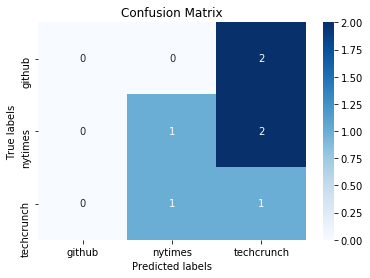

In [144]:
cm = confusion_matrix(groundtruth, prediction, labels=sources)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(sources)
ax.yaxis.set_ticklabels(sources)
plt.savefig("./txtcls_cm.png")

## Examine eval metrics by model version or timestamp

By specifying the same evaluation table, two different model versions can be evaluated. Also, since the timestamp is captured, it is straightforward to evaluation model performance over time. 

In [152]:
now = pd.Timestamp.now(tz='UTC')
one_week_ago = now - pd.DateOffset(weeks=1)
one_month_ago = now - pd.DateOffset(months=1)

In [156]:
df_prev_week = df_results[df_results.time > one_week_ago]
df_prev_month = df_results[df_results.time > one_month_ago]

In [157]:
df_prev_month

,model,model_version,time,text,prediction,confidence,groundtruth
0,txtcls,swivel,2020-06-26 03:15:12+00:00,A Filmmaker Put Away for Tax Fraud Takes Us In...,techcrunch,0.42,nytimes
1,txtcls,swivel,2020-06-26 03:15:21+00:00,House Passes Sweeping Policing Bill Targeting ...,nytimes,0.52,nytimes
2,txtcls,swivel,2020-06-26 03:15:15+00:00,A native Mac app wrapper for WhatsApp Web,techcrunch,0.48,github
3,txtcls,swivel,2020-06-26 03:15:23+00:00,Scrollability,techcrunch,0.51,github
4,txtcls,swivel,2020-06-26 03:15:09+00:00,YouTube introduces Video Chapters to make it e...,techcrunch,0.51,techcrunch
5,txtcls,swivel,2020-06-26 03:15:17+00:00,Astronauts Dock With Space Station After Histo...,techcrunch,0.51,nytimes
6,txtcls,swivel,2020-06-26 03:15:26+00:00,iOS 14 lets deaf users set alerts for importan...,nytimes,0.48,techcrunch


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License